# **Shot ambient binary classification: VGG16 + Logistic Regression**

## In this notebook, a binary classification task of the different ambient of cinematographic shots has been implemented. The implemented approach exploits the VGG16 neural network to extract the relevant information from each image (featurization), i.e. the features, while a Logistic Regression model has the task of classifying these images among the 2 classes present:

*   ### Interior
![picture](https://drive.google.com/uc?id=1wurH7emiuOCXY-Ta7aazdYk0GEB9PbTv)
*   ### Exterior
![picture](https://drive.google.com/uc?id=1XAb4CyD6kStmHO7X3BXnrugoLYmH8E0j)

# **0. Spark + Google Colab Setup**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "<path>"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "<path>"
GDRIVE_DATA_CSV = GDRIVE_HOME_DIR + "<path>"
RANDOM_SEED = 42

import os
os.environ["JAVA_HOME"] = JAVA_HOME

In [ ]:
# Point Colaboratory to our Google Drive
from google.colab import drive
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


## **0.1.** Install PySpark and related dependencies

In [ ]:
!pip install pyspark
!apt install openjdk-8-jdk-headless -qq

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.serializers import PickleSerializer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=61fe20fbf1544c5e71fde1fd58f401a8fd48ce90c35551580795637c29427308
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:a

## **0.2.** Create Spark context

In [ ]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("shot_ambient_logistic_regression").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# **1. Useful imports**

In [ ]:
import PIL.Image as Image
from PIL import ImageFilter
import io

import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
import pandas as pd
import imutils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

from pyspark.sql.functions import col, udf, pandas_udf, PandasUDFType
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml.linalg import VectorUDT, Vectors

# **2. Load data for shot ambient binary classication task**

## Read shot ambient tagged image from parquet file into pyspark df

In [ ]:
from pyspark.sql import functions as F
url = GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/shot_ambient_binary_data_7000.parquet"
ambient_df = spark.read.parquet(url).select("*").orderBy(F.rand(RANDOM_SEED)).drop("path")

## Split and save data in train and test sets


In [ ]:
train, test= ambient_df.randomSplit([0.7, 0.3])

In [ ]:
train.write.mode("overwrite").parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/LogisticRegression/data/train.parquet")
test.write.mode("overwrite").parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/LogisticRegression/data/test.parquet")

## Load train and test sets

In [ ]:
train = spark.read.parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/LogisticRegression/data/train.parquet")
test = spark.read.parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/LogisticRegression/data/test.parquet")

# **3. Image preprocessing**

### For this approach we decided to use two different types of preprocessing to apply to the images:

> ### **1.   Rgb**
> ### **2.   Grayscale**

### The chosen preprocessings are shown below:
![picture](https://drive.google.com/uc?id=1-Z2s2_7m0jPifzkUIbNhqzHi5Rp2oytL)

## Function thath applies Grayscale preprocessing and VGG16 preprocess_input function


In [ ]:
def preprocess_grayscale(binary_data):
  img = Image.open(io.BytesIO(binary_data)).resize((224,224))

  # Check the shape of image and convert it to 'L' mode
  if img.mode == 'RGB':
    img = img.convert('L')

  # Convert grayscale image to RGB format
  rgb_image = np.stack((img,) * 3, axis=-1)

  # Convert RGB image to array
  input_data = img_to_array(rgb_image)

  # Preprocess the input data
  return preprocess_input(input_data)

## Function thath applies RGB preprocessing and VGG16 preprocess_input function


In [ ]:
def preprocess_rgb(binary_data):
  img = Image.open(io.BytesIO(binary_data)).resize((224,224))

  # Check the shape of image and convert it to 'L' mode
  if img.mode == 'L':
    img = img.convert('RGB')

  # Convert RGB image to array
  input_data = img_to_array(img)

  # Preprocess the input data
  return preprocess_input(input_data)

# **4. VGG16 Feature extraction**

## VGG16 consists in a total of 16 layers, with the majority being convolutional layers (13 in total) and the remaining layers being fully connected.The convolutional layers in VGG16 are constructed using 3x3 filters. After each convolutional layer, VGG16 incorporates a max-pooling layer with a 2x2 window and a stride of 2. Its architecture is shown below:
![picture](https://drive.google.com/uc?id=1IK5cRXbETxECkEV2VHc-VT_CQe4Jd3it)

## Functions to apply the specified preprocessing function to each image in the shot type dataset and then extract the features thanks to the instance of the VGG16 neural network model.

In [ ]:
def get_features(model, image):
  # Apply specified preprocessing function to the image
  input = np.stack(image.map(preprocess_rgb))

  # Extract the features using the model
  predictions = model.predict(input)

  # Flatten the features
  features = [x.flatten() for x in predictions]

  return pd.Series(features)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def preprocess_udf(column):
  # Initialize VGG16 model
  VGG_model = VGG16(weights='imagenet', include_top=False)

  # Set all layers in VGG_model as non-trainable
  for layer in VGG_model.layers:
    layer.trainable = False

  # Iterate over each image in the column
  for image in column:
    # Yield the features obtained from get_features function
    yield get_features(VGG_model, image)

## UDF function to transform the array of features into a Vector

In [ ]:
get_vectorized_features_udf = udf(lambda features: Vectors.dense(features), VectorUDT())

## Save train and test features for further usage

In [ ]:
# Save training features df
train = train.withColumn("content", preprocess_udf(train['content']))
train = train.withColumn("features", get_vectorized_features_udf("content")).drop("content")
train.write.mode("overwrite").parquet("/content/drive/My Drive/Big_Data/shot_ambient/LogisticRegression/features/InceptionV3_training_features_grayscale.parquet")

In [ ]:
# Save test features df
test = test.withColumn("content", preprocess_udf(test['content']))
test = test.withColumn("features", get_vectorized_features_udf("content")).drop("content")
test.write.mode("overwrite").parquet("/content/drive/My Drive/Big_Data/shot_ambient/LogisticRegression/features/InceptionV3_test_features_grayscale.parquet")

## Load train and test feature sets

In [ ]:
# Load train and test features sets
train = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_ambient/LogisticRegression/features/VGG16_training_features_grayscale.parquet')
test = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_ambient/LogisticRegression/features/VGG16_test_features_grayscale.parquet')

# **5. Logistic Regression classification**

## Logistic regression is a popular statistical model used for binary classification tasks. It is a type of generalized linear model (GLM) that predicts the probability of an instance belonging to a particular class. The model calculates a weighted sum of the input features and applies a non-linear sigmoid function to produce the predicted probability.
## In particular we decided to perform parameter tuning using cross-validation, and obtain the best model for binary classification using Logistic regression. The parameters selected for tuning are:

 *   ## **regParam**: controls the strength of the regularization. It is a non-negative value that determines the amount of weight given to the regularization term in the overall loss function.
 *   ## **elasticNetParam**: combines both L1 (Lasso) and L2 (Ridge) regularization methods. It is a value between 0 and 1 that determines the mix of L1 and L2 regularization.

## Label encoding on train and test sets

In [ ]:
# Get encoded labels
labels_dict = {
    'interior' : 0,
    'exterior' : 1
}

get_encoded_labels_udf = udf(lambda label : labels_dict[label], IntegerType())

In [ ]:
train = train.withColumn("label", get_encoded_labels_udf("ambient"))
test = test.withColumn("label", get_encoded_labels_udf("ambient"))

In [ ]:
train.printSchema()

root
 |-- ambient: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



## Parameter tuning of the Logistic Regression model

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import PipelineModel
from pyspark.ml.tuning import CrossValidatorModel
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [ ]:
# Create a LogisticRegression instance
logistic_reg = LogisticRegression(labelCol="label", featuresCol="features")

# Define the parameter grid for grid search
param_grid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logistic_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Evaluator of the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create the cross-validator with the logistic regression model and parameter grid
cross_validator = CrossValidator(estimator=logistic_reg,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=5)

# Train the logistic regression model with cross-validation
cv_model = cross_validator.fit(train)

### Save the model with the best params

In [ ]:
cv_model.save('/content/drive/My Drive/Big_Data/shot_ambient/models/VGG_cvModel_grayscale')

# **6. Evaluation**

## Load all test feature sets


In [ ]:
vgg_test_rgb = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_ambient/LogisticRegression/features/VGG16_test_features_rgb.parquet')
vgg_test_grayscale = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_ambient/LogisticRegression/features/VGG16_test_features_grayscale.parquet')

## Load cvModels

In [ ]:
vgg_rgb_model = CrossValidatorModel.load("/content/drive/My Drive/Big_Data/shot_ambient/models/VGG_cvModel_rgb")
vgg_grayscale_model = CrossValidatorModel.load("/content/drive/My Drive/Big_Data/shot_ambient/models/VGG_cvModel_grayscale")

## Define evalution lists


In [ ]:
models_list = [vgg_rgb_model, vgg_grayscale_model]
test_sets_list = [vgg_test_rgb, vgg_test_grayscale]
titles = ["VGG16 with rgb preprocessing", "VGG16 with grayscale preprocessing"]

## Add encoded labels to test sets

In [ ]:
test_sets_list = [test.withColumn("label", get_encoded_labels_udf("ambient")) for test in test_sets_list]

## Compute precision and recall curves, receiving operating characteristics curves, and confusion matrices

- Params : {'elasticNetParam': 0.0, 'regParam': 1.0}


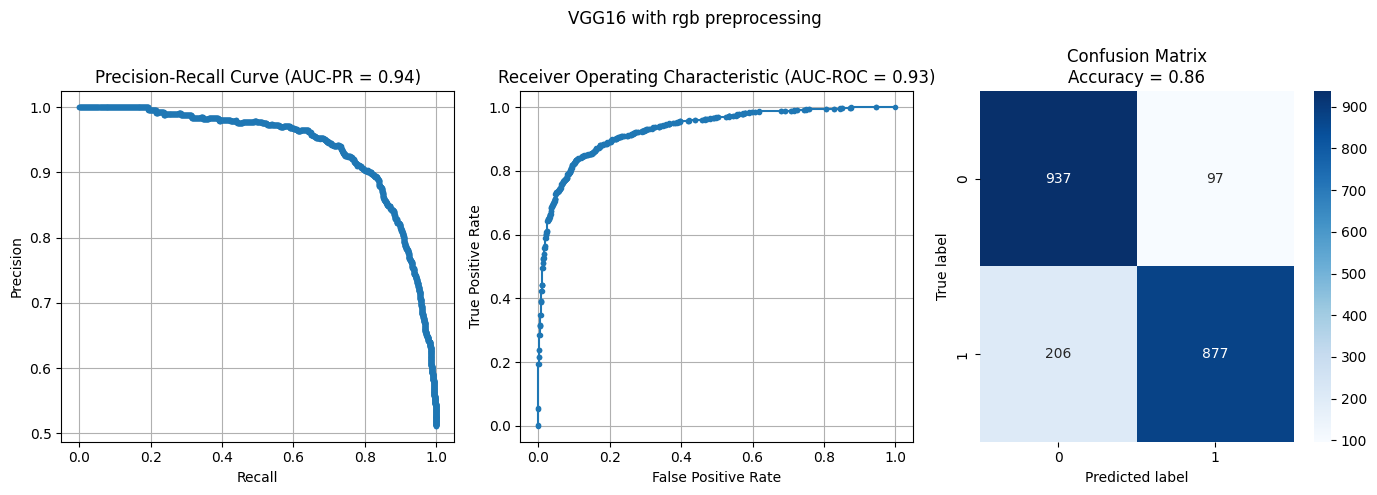

- Params : {'regParam': 1.0, 'elasticNetParam': 0.0}


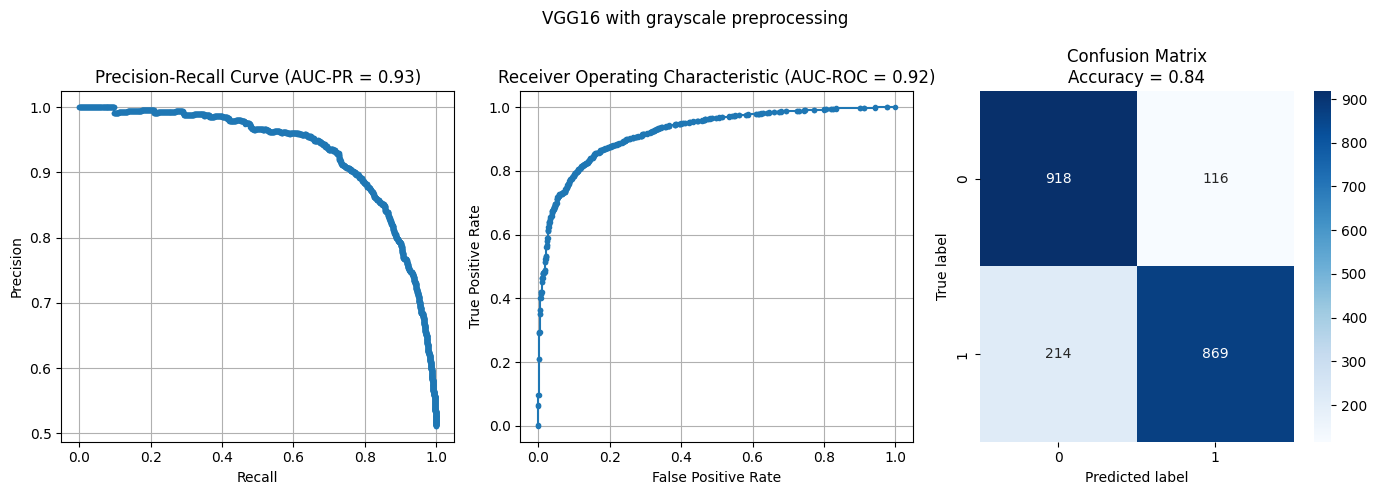

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, confusion_matrix

# Filter and ignore the specific warning
warnings.filterwarnings("ignore", category=FutureWarning, module="pyspark.sql")

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

for model, test, title in zip(models_list, test_sets_list, titles):
    # Make predictions on the test set using the best model
    predictions = model.transform(test)

    # Convert the 'label' and 'prediction' columns to float
    predictions = predictions.withColumn("label", col("label").cast("float"))

    prediction_and_labels = predictions.select("label","prediction").rdd
    # Extract true labels and predicted labels
    true_labels = prediction_and_labels.map(lambda x: x[0]).collect()
    predicted_labels = prediction_and_labels.map(lambda x: x[1]).collect()

    # CGet scores
    scores = np.array(predictions.select("rawPrediction").rdd.map(lambda x: x[0][1]).collect())

    # Compute precision, recall, and thresholds for Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(true_labels, scores)
    pr_auc = auc(recall, precision)

    # Compute false positive rate, true positive rate, and thresholds for ROC curve
    fpr, tpr, thresholds_roc = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)

    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Interior', 'Exterior'])

    params_dict = model.getEstimatorParamMaps()[np.argmax(model.avgMetrics)]
    d = {key.name : value for key, value in params_dict.items()}
    print(f"- Params : {d}")

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Plot Precision-Recall curve
    plt.figure(figsize=(14, 5))
    plt.suptitle(title)
    plt.subplot(1, 3, 1)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (AUC-PR = %0.2f)' % pr_auc)
    plt.grid(True)

    # Plot ROC curve
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (AUC-ROC = %0.2f)' % roc_auc)
    plt.grid(True)

    # Plot confusion matrix using Seaborn
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix\nAccuracy = %0.2f' % accuracy)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

    plt.show()

## Funtion to define VGG16 model

In [ ]:
def model_definition():
  VGG16_model = VGG16(weights='imagenet', include_top=False)

  for layer in VGG16_model.layers:
    layer.trainable=False

  return VGG16_model

## Functions to test the models on new samples


In [ ]:
def get_sample_features(img, preprocess_function):
  model = model_definition()

  # apply preprocessing function to the image
  input = preprocess_function(img)

  input = np.expand_dims(input, axis=0)

  # extract the image features
  preds = model.predict(input, verbose=0)
  features = [x.flatten() for x in preds]

  return features

## Function to plot new samples with scores

In [ ]:
def plot_image_with_scores(img_path, label, df, i):
    # Load the image
    image = Image.open(img_path).resize((320, 200))

    fig = plt.figure(figsize=(23, 5))

    # setting values to rows and column variables
    rows = 1
    columns = 2

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    plt.title(str(i) + '  ' + label)

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    table = plt.table(cellText=df.values, colLabels=df.columns, loc='center', bbox=[0, 0, 1, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(1, 1.5)  # Adjust the values to center the table vertically
    plt.axis('off')

    plt.tight_layout()  # Ensures that the subplots and labels are properly centered
    plt.show()

## Function to perform predictions on new samples

In [ ]:
def softmax(z):
    assert len(z.shape) == 2

    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div

def prediction_sample(img_path, preprocessing_type):

  # preparing img
  with open(img_path, 'rb') as file:
    img = file.read()

  match preprocessing_type:
    case "rgb":
      features = get_sample_features(img, preprocess_rgb)
      model = vgg_rgb_model

    case "grayscale":
      features = get_sample_features(img, preprocess_grayscale)
      model = vgg_grayscale_model

  features = features[0].tolist()

  data = [(features,)]

  schema = StructType([StructField("features", ArrayType(FloatType()))])

  # put the new features into a new spark df
  img_df = spark.createDataFrame(data=data, schema=schema)

  # transform the features in a vector
  img_df = img_df.withColumn("features", get_vectorized_features_udf("features"))

  # get the prediction
  prediction = model.transform(img_df)

  # transform the prediction in the appropriate format
  predictions = prediction.select('rawPrediction')

  raw_preds = [row[0] for row in predictions.collect()][0].values.tolist()

  # apply softmax function to get classes prediction percentages
  final_preds = softmax(np.array([raw_preds]))

  classes = ['interior', 'exterior']

  return [ '%.4f' % elem for elem in list(final_preds[0]) ]

In [ ]:
directory = "/content/drive/My Drive/Big_Data/shot_ambient/shot_ambient_samples/"

i = 1
for sample_path in os.listdir(directory):
  label = sample_path.split('/')[-1].split('_')[0]
  result_df = pd.DataFrame([], columns=['labels', 'rgb', 'grayscale'])

  result_df['labels'] = ['interior', 'exterior']
  result_df['rgb'] = prediction_sample(os.path.join(directory, sample_path), "rgb")
  result_df['grayscale'] = prediction_sample(os.path.join(directory, sample_path), "grayscale")
  plot_image_with_scores(os.path.join(directory, sample_path), label, result_df, i)
  i += 1

Output hidden; open in https://colab.research.google.com to view.

# **7. Conclusions**

### The two models proposed obtain very similar results, both in terms of Accuracy and ROC and PR areas. Between the two, the one that performs slightly better is the one trained on preprocessed data using rgb values. Looking at both AUC values for the Precision/Recall and ROC curves, we can state that both models offer a high level of discrimination and classification performance. Furthermore, observing the tests carried out on the new samples, it can be seen how the models behave in different situations. In the case of the first sample, in fact, relating to the film 'mad max' there is a background of the scene that is very clear and not outlined which may not give reference points regarding the setting. Looking at this example, we can see a considerable extra security of the model based on grayscale compared to the one based on rgb. Which demonstrates that the model based on grayscale preprocessing performs better at least on some special cases. Another interesting example is number 4 which depicts the final scene of the movie 'fight club'. In particular, this scene depicts two people in front of a large window overlooking the city. In this situation both models return an incorrect result for the ambient, which is probably due to the fact that the city in the background is classified as an exterior ambient element even if the two characters are inside a room. This example, although returning a negative result, highlights the fact that the models are able to correctly identify elements relating to exterior ambient.

## **CNN vs VGG16 + Logistic Regression**



### It seems that the VGG16 + Logistic Regression model classifies in a more accurate way the images, reaching an accuracy of 86% instead of 78% (accuracy of the CNN). We think that this behaviour is pretty logic because of the difference of layers between the CNN and the VGG16. Also combining a neural network and a machine learning algorithm could be a better choice for higher accuracy. There is no particular difference between the preprocessing used, meaning that in future we can use different type of preprocessing to maybe see better results. Maybe instead of RGB we could use HSV or HSL or maybe combining them together to have a wider comprehension of the images.